In [132]:
import rioxarray as rix
import os
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry
from shapely.geometry import LineString
import math
import pandas as pd

In [2]:
ls -lah /Users/elischwat/Development/data/sublimationofsnow/RMBL_dronedata/processed/Dronedata_KettlePonds_2024_04_24/mosaics_clipped/cog/

total 75461648
drwxr-xr-x   8 elischwat  staff   256B Oct  7 12:52 ./
drwx------  28 elischwat  staff   896B Oct  7 12:16 ../
-rw-r--r--   1 elischwat  staff   5.5G Oct  7 12:49 LundquistSnowHydro_KettlePonds_Altum_2024_04_24_Flight1_ortho_reflectance_clipped_cog.tif
-rw-r--r--   1 elischwat  staff   3.0G Oct  7 12:50 LundquistSnowHydro_KettlePonds_Altum_2024_04_24_Flight2_ortho_reflectance_clipped_cog.tif
-rw-r--r--   1 elischwat  staff   3.7G Oct  7 12:51 LundquistSnowHydro_KettlePonds_Altum_2024_04_24_Flight3_ortho_reflectance_clipped_cog.tif
-rw-r--r--   1 elischwat  staff   1.0G Oct  7 12:52 LundquistSnowHydro_KettlePonds_P1_2024_04_24_dsm_clipped_cog.tif
-rw-r--r--   1 elischwat  staff   1.1G Oct  7 12:52 LundquistSnowHydro_KettlePonds_P1_2024_04_24_ht_above_DEM_cog.tif
-rw-r--r--   1 elischwat  staff    22G Oct  7 13:04 LundquistSnowHydro_KettlePonds_P1_2024_04_24_ortho_clipped_cog.tif


In [3]:
directory = "/Users/elischwat/Development/data/sublimationofsnow/RMBL_dronedata/processed/Dronedata_KettlePonds_2024_04_24/mosaics_clipped/cog/"

In [4]:
src = rix.open_rasterio(
    os.path.join(directory, "LundquistSnowHydro_KettlePonds_Altum_2024_04_24_Flight1_ortho_reflectance_clipped_cog.tif"),
    chunks='auto',
    masked=True
)

(array([1.13106073e+08, 2.52419820e+07, 4.49552900e+06, 6.39409600e+06,
        1.60281500e+07, 3.47182650e+07, 2.91742090e+07, 3.57252800e+06,
        1.61312000e+05, 2.80200000e+03]),
 array([0.        , 0.1344635 , 0.26892701, 0.4033905 , 0.53785402,
        0.6723175 , 0.80678099, 0.94124448, 1.07570803, 1.21017146,
        1.34463501]),
 <BarContainer object of 10 artists>)

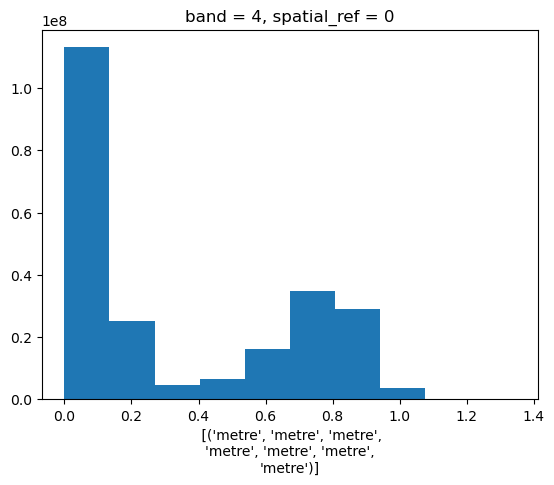

In [5]:
src.sel(band=4).plot.hist()

In [8]:
src

<xarray.DataArray (band: 7, y: 28902, x: 18158)> Size: 15GB
dask.array<open_rasterio-5489628386e40951fe38c8c2082f39b0<this-array>, shape=(7, 28902, 18158), dtype=float32, chunksize=(1, 5632, 5632), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 145kB 3.286e+05 3.286e+05 ... 3.295e+05 3.295e+05
  * y            (y) float64 231kB 4.313e+06 4.313e+06 ... 4.312e+06 4.312e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        1.0349943637848
    STATISTICS_MEAN:           0.28658713502201
    STATISTICS_MINIMUM:        7.5086785500389e-07
    STATISTICS_STDDEV:         0.28113522434277
    STATISTICS_VALID_PERCENT:  45.08
    scale_factor:              1.0
    add_offset:                0.0
    units:                     ('metre', 'metre', 'metre', 'metre', 'metre', ...

In [20]:
scale_factor = 0.05
new_width = int(src.sel(band=6).rio.width * scale_factor)
new_height = int(src.sel(band=6).rio.height * scale_factor)
print((new_height, new_width))
irband_lowres = src.sel(band=6).rio.reproject(
    src.rio.crs,
    shape=(new_height, new_width),
)

(1445, 907)


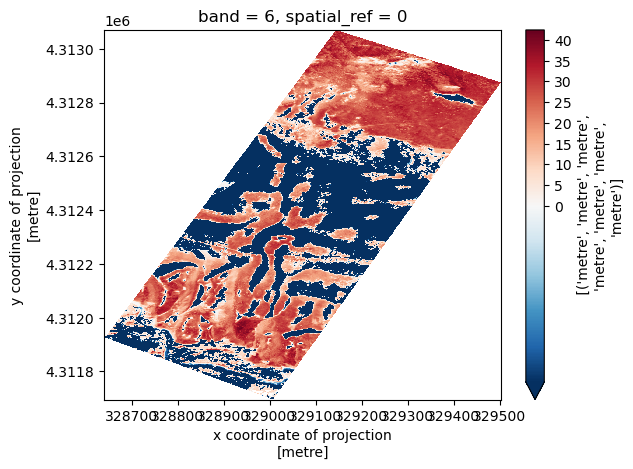

In [26]:


# Define the colormap and normalization
cmap = plt.cm.RdBu_r  # Red-Blue colormap
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=irband_lowres.max())

# Plot with the custom colormap and normalization
irband_lowres.plot(cmap=cmap, norm=norm)

In [33]:
bounds = gpd.read_file("/Users/elischwat/Development/data/sublimationofsnow/RMBL_dronedata/vector/bounding_geometry.shp")

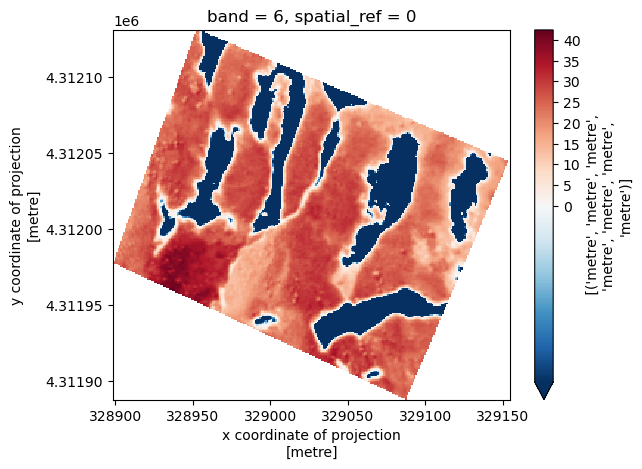

In [66]:
irband_lowres_clipped = irband_lowres.rio.clip(bounds.geometry, drop=True)
irband_lowres_clipped.plot(cmap=cmap, norm=norm)

In [115]:
# Extract the coordinates of the top left
start_x = irband_lowres_clipped.x.min().item()
start_y = irband_lowres_clipped.y.max().item()


# Step 3: Calculate the endpoint using the bearing
def calculate_endpoint(x, y, bearing, distance):
    # Convert bearing to radians
    bearing_rad = - np.deg2rad(bearing) - np.deg2rad(90)
    # Calculate the new coordinates
    end_x = x - distance * math.cos(bearing_rad)
    end_y = y - distance * math.sin(bearing_rad)
    return end_x, end_y

In [124]:
end_x, end_y = calculate_endpoint(start_x, start_y, 135, 350)

# Step 4: Create the LineString
line = LineString([(start_x, start_y), (end_x, end_y)])

print("LineString:", line)

# Assume `line` is your existing LineString
# Define the resolution (10 cm = 0.1 units)
resolution = 0.1

# Step 1: Calculate the total length of the line
line_length = line.length

# Step 2: Generate points at intervals of 10 cm
num_points = int(line_length / resolution) + 1
interpolated_points = [line.interpolate(distance) for distance in np.linspace(0, line_length, num_points)]

# Step 3: Create a new LineString with the interpolated points
high_res_line = LineString(interpolated_points)

list(high_res_line.coords)

LineString: LINESTRING (328898.940023102 4312130.713525143, 329146.42739651725 4311883.226151728)


[(328898.940023102, 4312130.713525143),
 (328899.0107337801, 4312130.642814466),
 (328899.0814444582, 4312130.572103787),
 (328899.15215513634, 4312130.50139311),
 (328899.22286581446, 4312130.430682431),
 (328899.2935764926, 4312130.359971753),
 (328899.3642871707, 4312130.289261075),
 (328899.4349978488, 4312130.218550397),
 (328899.50570852694, 4312130.1478397185),
 (328899.57641920506, 4312130.077129041),
 (328899.6471298832, 4312130.006418362),
 (328899.7178405613, 4312129.935707685),
 (328899.7885512394, 4312129.864997006),
 (328899.85926191753, 4312129.794286328),
 (328899.92997259565, 4312129.72357565),
 (328900.00068327377, 4312129.652864972),
 (328900.0713939519, 4312129.582154294),
 (328900.14210463, 4312129.511443616),
 (328900.2128153081, 4312129.440732937),
 (328900.28352598625, 4312129.37002226),
 (328900.35423666437, 4312129.299311581),
 (328900.4249473425, 4312129.228600903),
 (328900.4956580206, 4312129.157890225),
 (328900.5663686987, 4312129.087179547),
 (328900.637

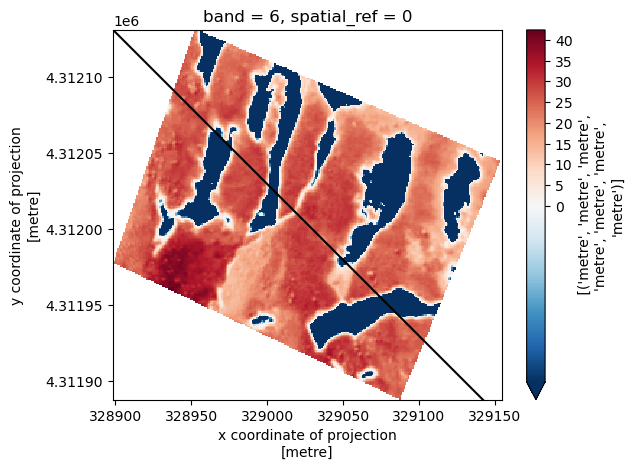

In [127]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=[high_res_line]).plot(color='black', ax=ax)
irband_lowres.rio.clip(bounds.geometry).plot(cmap=cmap, norm=norm, ax=ax)

In [175]:
points = list(high_res_line.coords)
# Initialize a list to store sampled values
sampled_values = []
distances = []

first_point = points[0]
# Loop through each point and sample the value in irband_lowres
for point in points:
    x, y = point  # Extract x and y coordinates
    value = irband_lowres.sel(x=x, y=y, method="nearest").item()  # Sample value
    sampled_values.append(value)
    distance = np.sqrt((x - first_point[0])**2 + (y - first_point[1])**2)
    distances.append(distance)

# Convert sampled values to a numpy array (optional)
sampled_values = np.array(sampled_values)

sample_df = pd.DataFrame({
    'temp': sampled_values,
    'distance': distances
}).set_index('distance')

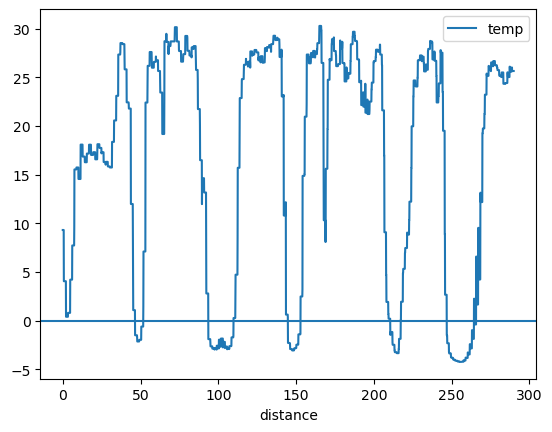

In [176]:
sample_df.plot()
plt.axhline(0)

In [177]:
sample_df['temp'] = sample_df['temp'].rolling(20, center=True).mean()

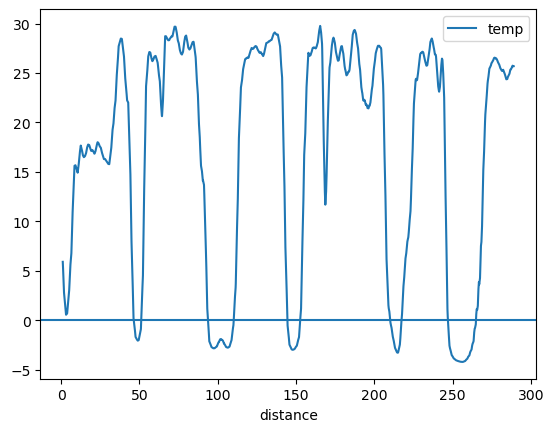

In [179]:
sample_df.plot()
plt.axhline(0)

In [180]:
# Step 1: Identify segments where temp < 0
sample_df['below_zero'] = sample_df['temp'] < 0

# Step 2: Group consecutive indices where temp < 0
sample_df['segment'] = (sample_df['below_zero'] != sample_df['below_zero'].shift()).cumsum()

# Step 3: Calculate the length of each segment where temp < 0
segment_lengths = (
    sample_df[sample_df['below_zero']]
    .groupby('segment')
    .apply(lambda group: group.index[-1] - group.index[0])
)

# Display the lengths of segments below 0
print("Lengths of segments where temp < 0:")
print(segment_lengths)

Lengths of segments where temp < 0:
segment
2      4.6
4     16.3
6      8.1
8      7.1
10    17.8
dtype: float64


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_49604/15573196.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.index[-1] - group.index[0])
